[INFO] Loaded X shape = (296, 39)
[INFO] Columns: ['b1', 'b2', 'p1', 'p2', 'p3', 'p4', 'sss', 'sst', 'Fe', 'PP', 'Si', 'NO3', 'CHL', 'PHYC', 'PO4', 'O2', 'vgosa', 'vgos', 'sla', 'ugosa', 'ugos', 'wind_stress', 'eastward_wind', 'surface_downward_eastward_stress', 'wind_speed', 'surface_downward_northward_stress', 'northward_wind', 'ftle_bw_sla', 'disp_bw_sla', 'AOU_WOA_clim', 'density_WOA_clim', 'o2sat_WOA_clim', 'oxygen_WOA_clim', 'salinity_WOA_clim', 'conductivity_WOA_clim', 'nitrate_WOA_clim', 'phosphate_WOA_clim', 'silicate_WOA_clim', 'par']
[INFO] True changepoints = [np.int64(22), np.int64(120)]
[INFO] Using covariates: ['p1', 'p2', 'p3', 'p4', 'sss', 'sst', 'Fe', 'PP', 'Si', 'NO3', 'CHL', 'PHYC', 'PO4', 'O2', 'vgosa', 'vgos', 'sla', 'ugosa', 'ugos', 'wind_stress', 'eastward_wind', 'surface_downward_eastward_stress', 'wind_speed', 'surface_downward_northward_stress', 'northward_wind', 'ftle_bw_sla', 'disp_bw_sla', 'AOU_WOA_clim', 'density_WOA_clim', 'o2sat_WOA_clim', 'oxygen_WOA_c

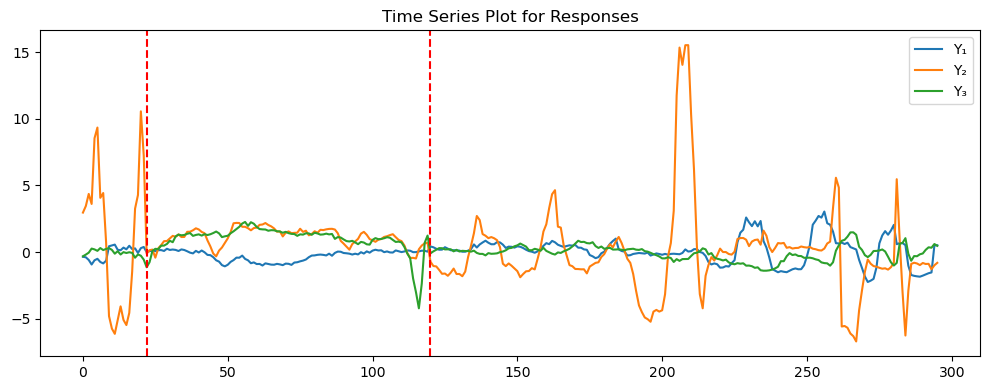

In [1]:
import torch, random, io, sys, warnings
import os, numpy as np, pandas as pd, pyreadr, matplotlib.pyplot as plt
from scipy.special import softmax
from data_generator import generate_gmm_data_segments
from tqdm import tqdm
from cpd_model import parse_args, learn_one_seq_penalty


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# ======================================================
# 1. Load X (RDS DataFrame)
# ======================================================
result = pyreadr.read_r("realx.RDS")
X_df = list(result.values())[0]
print(f"[INFO] Loaded X shape = {X_df.shape}")
print(f"[INFO] Columns: {list(X_df.columns)}")

pos1 = np.where(X_df["b1"].values == 1)[0][0]
pos2 = np.where(X_df["b2"].values == 1)[0][0]
true_cp = [pos1, pos2]
print(f"[INFO] True changepoints = {true_cp}")

# ======================================================
# 2. Define mean / weight functions (linear + par-dominant version)
# ======================================================

cols = [c for c in X_df.columns if c not in ["b1", "b2"]]
p = len(cols)
print(f"[INFO] Using covariates: {cols}")

# identify "par" column index
par_idx = cols.index("par") if "par" in cols else 0
print(f"[INFO] 'par' variable index = {par_idx}")

# helper: linear mean function
def make_linear_mean(beta_mat, bias):
    """f(x) = beta_mat @ x + bias, beta_mat shape = (dy, p)"""
    beta_mat = np.asarray(beta_mat)
    bias = np.asarray(bias)
    return lambda x: beta_mat @ x

# helper: linear weight (exclude par)
def make_weight(beta_w):
    """softmax(W @ x_no_par)"""
    beta_w = np.asarray(beta_w)
    def func(x):
        x_wo_par = np.delete(x, par_idx)  # exclude par from weights
        return softmax(beta_w @ x_wo_par)
    return func

# ======================================================
# Define β_k for each segment (dy=3)
# ======================================================
dy = 3
rng = np.random.default_rng(77)

def make_betas(par_mean=0.0, par_scale=2.0, other_scale=0.1, sparse_par=True):
    """
    Make beta matrices where par affects only ONE Y-dimension (if sparse_par=True).
    """
    beta = rng.normal(0, other_scale, size=(dy, p))

    if sparse_par:
        # pick one active output dimension
        d_star = rng.integers(0, dy)
        par_vals = np.zeros(dy)
        par_vals[d_star] = rng.normal(par_mean, par_scale)
        beta[:, par_idx] = par_vals
    else:
        # par affects all dimensions
        beta[:, par_idx] = rng.normal(par_mean, par_scale, size=dy)
    return beta

# Segment 1: component1 par dominant
mean_funcs_seg1 = [
    make_linear_mean(make_betas(par_mean= 10, par_scale=1), np.zeros(dy)),  # comp1 active
    make_linear_mean(make_betas(par_mean= 0, par_scale=1), np.zeros(dy)),   # comp2 inactive
    make_linear_mean(make_betas(par_mean= 0, par_scale=1), np.zeros(dy)),   # comp3 inactive
]
weight_func_seg1 = make_weight(rng.normal(0, 0.5, size=(3, p-1)))

# Segment 2: component2 par dominant
mean_funcs_seg2 = [
    make_linear_mean(make_betas(par_mean= 0, par_scale=1), np.zeros(dy)),   # comp1 inactive
    make_linear_mean(make_betas(par_mean= -10, par_scale=1), np.zeros(dy)),  # comp2 active
    make_linear_mean(make_betas(par_mean= 0, par_scale=1), np.zeros(dy)),   # comp3 inactive
]
weight_func_seg2 = make_weight(rng.normal(0, 0.5, size=(3, p-1)))

# Segment 3: component3 par reversed (negative)
mean_funcs_seg3 = [
    make_linear_mean(make_betas(par_mean= 0, par_scale=1), np.zeros(dy)),   # comp1 inactive
    make_linear_mean(make_betas(par_mean= 0, par_scale=1), np.zeros(dy)),   # comp2 inactive
    make_linear_mean(make_betas(par_mean= 10, par_scale=1), np.zeros(dy)),  # comp3 negative
]
weight_func_seg3 = make_weight(rng.normal(0, 0.5, size=(3, p-1)))

mean_funcs_list = [mean_funcs_seg1, mean_funcs_seg2, mean_funcs_seg3]
weight_funcs_list = [weight_func_seg1, weight_func_seg2, weight_func_seg3]


# ======================================================
# 3. Repeat X (drop b1,b2)
# ======================================================
def repeat_X_3d(X_df, n_rep=100):
    X_cov = X_df.drop(columns=["b1", "b2"]).to_numpy()
    T, p = X_cov.shape
    X_repeat = np.repeat(X_cov[:, None, :], n_rep, axis=1)
    print(f"[INFO] X_repeat shape = {X_repeat.shape} (T={T}, N={n_rep}, P={p})")
    return X_repeat

nrep = 100
X = repeat_X_3d(X_df, n_rep=nrep)

# ======================================================
# 4. Generate data via generate_gmm_data_segments
# ======================================================
_, Y, comp_labels = generate_gmm_data_segments(
    X, mean_funcs_list, weight_funcs_list,
    change_points=[pos1, pos2],
    K=3, dy=3,
    mean_jitter=0.05,
    cov_scale=0.4
)
print(f"[INFO] Y shape = {Y.shape}")

import numpy as np


cps = [0] + true_cp + [comp_labels.shape[0]]
S = len(cps) - 1 

print(f"[INFO] Segment boundaries: {cps}")
for s in range(S):
    seg = comp_labels[cps[s]:cps[s+1]]  # (T_segment, N)
    vals, counts = np.unique(seg, return_counts=True)
    print(f"\nSegment {s+1}: t ∈ [{cps[s]}, {cps[s+1]})")
    for v, c in zip(vals, counts):
        print(f"  Component {int(v)}: {c} samples ({c/seg.size:.2%})")
# X = X[0:200, :, :3]
# Y = Y[0:200, :, :]
print(X.shape)
print(true_cp)
comp_labels.shape

for seg_id, seg in enumerate(mean_funcs_list, 1):
    print(f"\n=== Segment {seg_id} ===")
    for comp_id, f in enumerate(seg, 1):
        beta = f(np.eye(p))[..., par_idx] 
        print(f"Component {comp_id}: par beta ≈ {beta}")

        
# ======================================================
# 5. Visualize Y mean trajectories
# ======================================================
mean_Y = Y.mean(axis=1)
plt.figure(figsize=(10,4))
plt.plot(mean_Y[:,0], label='Y₁')
plt.plot(mean_Y[:,1], label='Y₂')
plt.plot(mean_Y[:,2], label='Y₃')
for cp in [pos1, pos2]:
    plt.axvline(cp, color='r', linestyle='--', lw=1.5)
plt.title("Time Series Plot for Responses")
plt.legend(); plt.tight_layout(); plt.show()


[INFO] Using device: cuda
[INFO] Best penalty selected = 0.1
Epoch   5 | Loss=464.675079 | SNR=53.494499
Epoch  10 | Loss=433.226074 | SNR=48.891262
Epoch  15 | Loss=417.346893 | SNR=41.055344
Epoch  20 | Loss=404.825409 | SNR=29.196499
Epoch  25 | Loss=391.834961 | SNR=26.094662
Epoch  30 | Loss=381.007111 | SNR=24.252710
Epoch  35 | Loss=370.787170 | SNR=25.377243
Epoch  40 | Loss=365.801361 | SNR=24.452333
Epoch  45 | Loss=358.521484 | SNR=25.762291
Epoch  50 | Loss=351.416718 | SNR=25.713358

[SNR-based model selection] Best epoch = 33, SNR = 19.997005



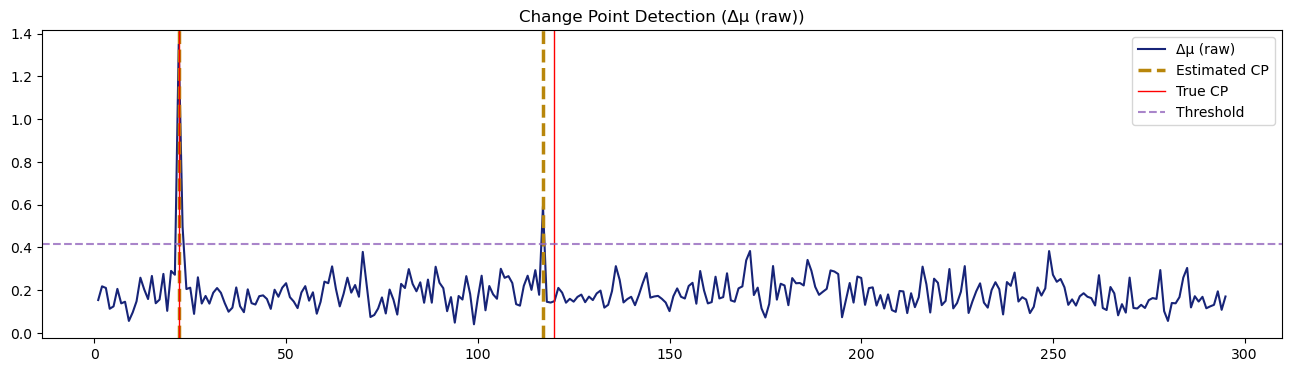

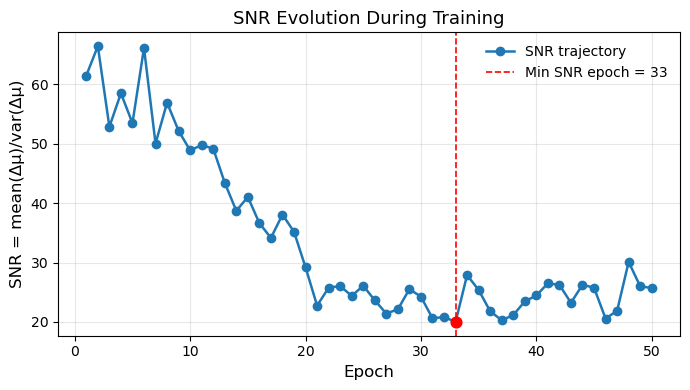

[INFO] Best epoch (min SNR): 33, SNR = 19.997005

[RESULT] True CPs = [np.int64(22), np.int64(120)]
[RESULT] Detected CPs = [22, 117]
[RESULT] Covering metric = 0.9799
[RESULT] abs_error = 0.0000


In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# ======================================================
# 7. Prepare args
# ======================================================
args = parse_args()
args.epoch = 50
args.z_dim = 5
args.x_dim = X.shape[2]
args.y_dim = Y.shape[2]
args.num_time = X.shape[0]
args.num_samples = X.shape[1]
args.decoder_lr = 0.0001
args.decoder_iteration = 200
args.langevin_s = 0.2
args.langevin_K = 100
args.kappa = 1
args.penalties = [0.01, 0.1, 1]
args.nu_iteration = 50
args.output_layer = [200, 200]
args.scale_y = True
args.scale_delta = False
args.signif_level = 0.99
args.true_CP_full = true_cp

# ======================================================
# 8. Prepare data tensors
# ======================================================
X_flat = X.reshape(-1, args.x_dim)
X_mean, X_std = X_flat.mean(axis=0, keepdims=True), X_flat.std(axis=0, keepdims=True) + 1e-8
X_flat = (X_flat - X_mean) / X_std
X_array = X_flat.reshape(args.num_time, -1, args.x_dim)

x_input = torch.tensor(X_array, dtype=torch.float32).to(device)
y_input = torch.tensor(Y.reshape(args.num_time, -1, args.y_dim), dtype=torch.float32).to(device)

# Split odd/even for penalty selection
odd_idx, even_idx = range(1, args.num_time, 2), range(0, args.num_time, 2)
x_train, x_test = x_input[odd_idx].reshape(-1, args.x_dim), x_input[even_idx].reshape(-1, args.x_dim)
y_train, y_test = y_input[odd_idx].reshape(-1, args.y_dim), y_input[even_idx].reshape(-1, args.y_dim)

# ======================================================
# 9. Penalty selection (half training)
# ======================================================
results_half = []
for penalty in args.penalties:
    _stdout = sys.stdout
    sys.stdout = io.StringIO()  # suppress printing
    try:
        loss, pen = learn_one_seq_penalty(args, x_train, y_train, x_test, y_test, penalty=penalty, half=True)
    finally:
        sys.stdout = _stdout
    results_half.append([loss, pen])

results_half = np.array(results_half)
best_idx = np.argmin(results_half[:, 0])
best_penalty = args.penalties[best_idx]
print(f"[INFO] Best penalty selected = {best_penalty}")

# ======================================================
# 10. Full training using best penalty (record SNR)
# ======================================================
result, snr_list, delta_mu_all = learn_one_seq_penalty(
    args,
    x_input.reshape(-1, args.x_dim),
    y_input.reshape(-1, args.y_dim),
    x_input.reshape(-1, args.x_dim),
    y_input.reshape(-1, args.y_dim),
    penalty=best_penalty,
    half=False
)
torch.cuda.empty_cache()

# ======================================================
# 11. Plot SNR trajectory
# ======================================================
import matplotlib.pyplot as plt
epochs = np.arange(1, len(snr_list) + 1)
best_idx_snr = int(np.argmin(snr_list))
best_snr = snr_list[best_idx_snr]

plt.figure(figsize=(7, 4))
plt.plot(epochs, snr_list, marker='o', lw=1.8, label='SNR trajectory')
plt.axvline(best_idx_snr + 1, color='red', linestyle='--', lw=1.2,
            label=f'Min SNR epoch = {best_idx_snr + 1}')
plt.scatter(best_idx_snr + 1, best_snr, color='red', s=60, zorder=5)
plt.title("SNR Evolution During Training", fontsize=13)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("SNR = mean(Δμ)/var(Δμ)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

print(f"[INFO] Best epoch (min SNR): {best_idx_snr + 1}, SNR = {best_snr:.6f}")

# ======================================================
# 12. Report results
# ======================================================
print(f"\n[RESULT] True CPs = {true_cp}")
print(f"[RESULT] Detected CPs = {result[5]}")
print(f"[RESULT] Covering metric = {result[3]:.4f}")
print(f"[RESULT] abs_error = {result[0]:.4f}")

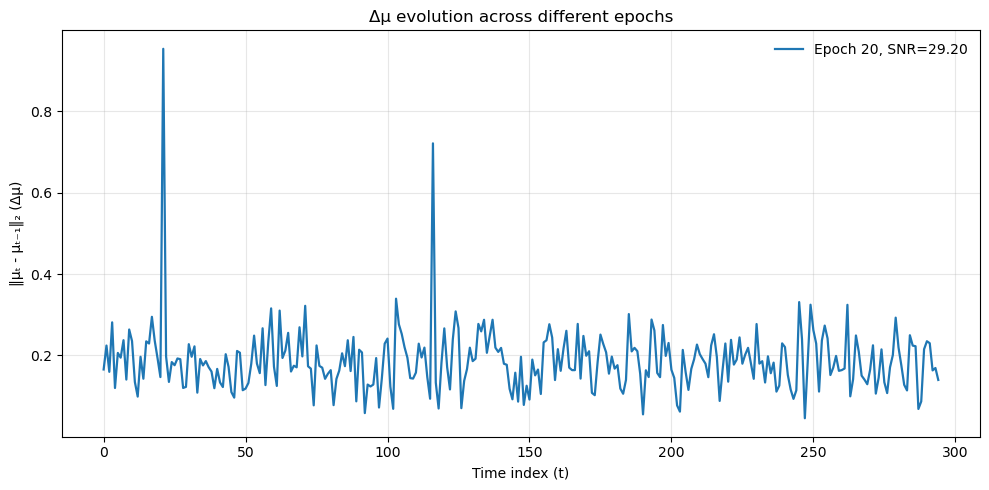

In [12]:
import matplotlib.pyplot as plt


epochs_to_show = [20]
plt.figure(figsize=(10, 5))

for e in epochs_to_show:
    if e <= len(delta_mu_all):
        plt.plot(delta_mu_all[e-1], lw=1.6, label=f"Epoch {e}, SNR={snr_list[e-1]:.2f}")

plt.xlabel("Time index (t)")
plt.ylabel("‖μₜ - μₜ₋₁‖₂ (Δμ)")
plt.title("Δμ evolution across different epochs")
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()
